In [5]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

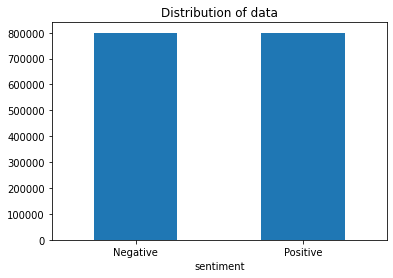

In [13]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [8]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [9]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


In [16]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 100 seconds


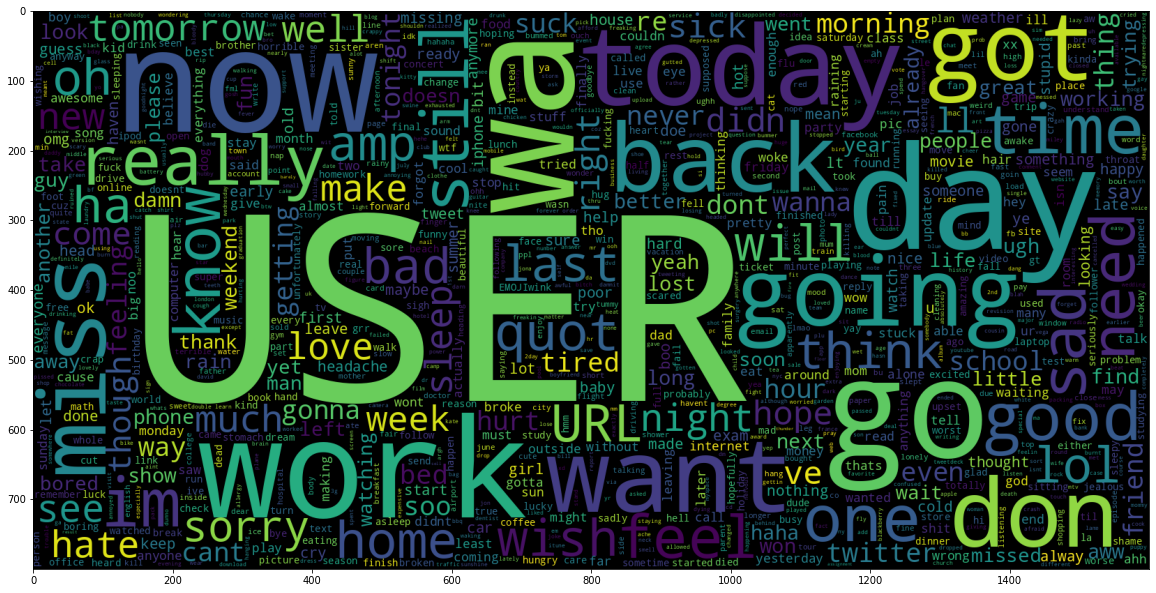

In [17]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

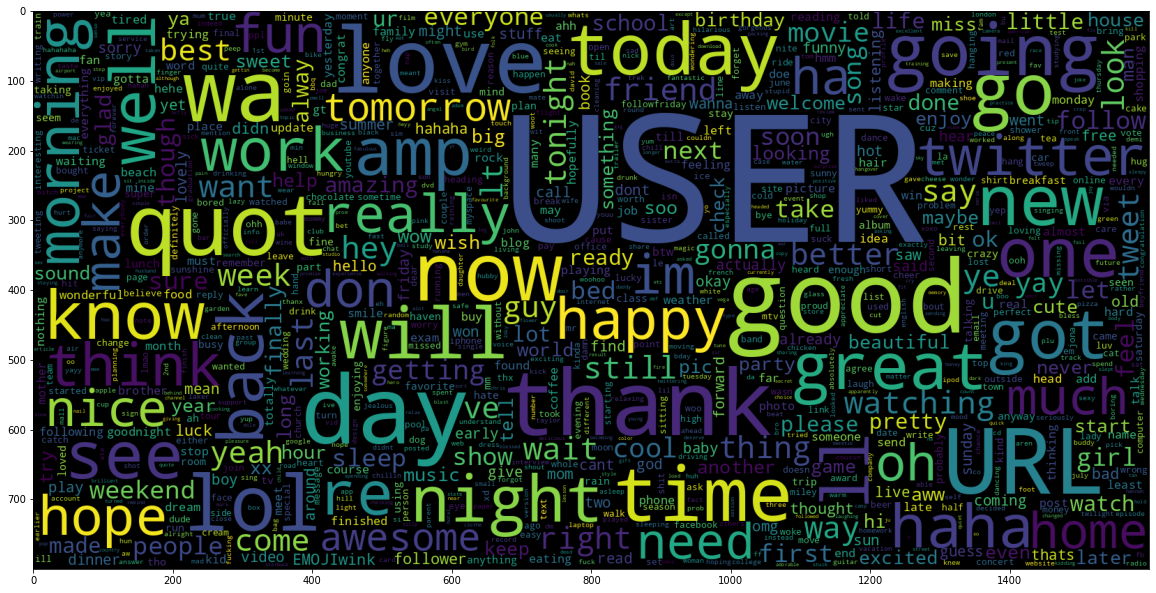

In [18]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [20]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [21]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [22]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



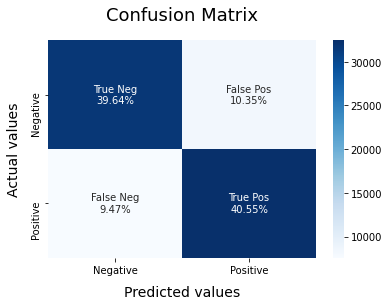

In [23]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



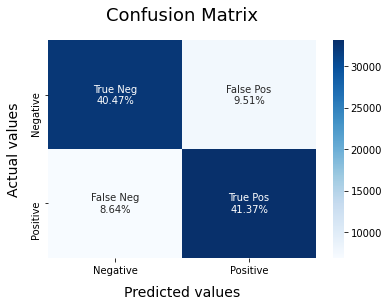

In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



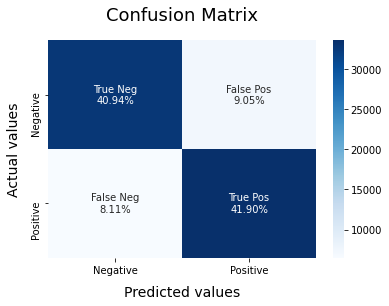

In [25]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [26]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [15]:
def load_models():
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1],["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    str=input("\n Enter text for analysis: ")


    text= [str] 
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())



 Enter text for analysis: we hate twitter
              text sentiment
0  we hate twitter  Negative


In [41]:
# apply model for scrapped tweet from twitter using twint

import twint
import nest_asyncio
nest_asyncio.apply()

# Configure
c = twint.Config()
c.Username = "ImranKhanPTI"
c.Search = "FBR"
c.Store_csv = True
c.Custom_csv = ["id", "user_id", "username", "tweet"]
c.Output = ("FBR.csv")    # store in FBR.csv file
twint.run.Search(c)

1410937912896757760 2021-07-02 17:26:27 +0500 <ImranKhanPTI> محصولات سےحاصل شدہ آمدن کو تاریخی مقام تک لے جانےاور مالی سال 20-21 کے دوران 4691 ارب کا ہدف عبور کر کے 4732 ارب روپے، جو گزشتہ برس سے18% زیادہ ہیں، جمع کرنے پر میں FBR کی کاوشوں کو سراہتا ہوں۔ یہ کارکردگی ہماری حکومت کی پالیسیز کے نتیجے میں ٹھوس معاشی بحالی کا منہ بولتا ثبوت ہے۔
1410823599565553676 2021-07-02 09:52:12 +0500 <ImranKhanPTI> I commend efforts of FBR in achieving historic level of tax revenues of Rs.4732 bn in 2020-21 - exceeding target of Rs 4691 bn &amp;18% higher than last year. This performance is testimony to the strong economic revival spurred by our government's policies.
1398625308643835904 2021-05-29 18:00:33 +0500 <ImranKhanPTI> کسی بھی مالی سال کےدوران پہلی مرتبہ 4000 ارب کا سنگ میل عبورکرنےپرمیں FBR کی کاوشوں کو سراہتا ہوں۔مئی تاجولائی کے دوران 4143 ارب کےمحصولات جمع ہوئے (شمارکا سلسلہ تاحال جاری ہے)جو سالِ رفتہ سے18% زیادہ ہیں۔حکومتی پالیسیوں سے حاصل ہونےوالی وسیع البنیاد معاشی بحالی کےیہ واضح آثارہ

In [42]:
# read from csv to data

import pandas as pd
data=pd.read_csv("FBR.csv")

In [43]:
#drop all column except those which are r required 
data.drop(data.columns.difference(['date','time','username','tweet']), 1, inplace=True)

In [44]:
data

,date,time,username,tweet
0,2021-07-02,17:26:27,imrankhanpti,محصولات سےحاصل شدہ آمدن کو تاریخی مقام تک لے ج...
1,2021-07-02,09:52:12,imrankhanpti,I commend efforts of FBR in achieving historic...
2,2021-05-29,18:00:33,imrankhanpti,کسی بھی مالی سال کےدوران پہلی مرتبہ 4000 ارب ک...
3,2021-05-29,15:34:27,imrankhanpti,I commend efforts of FBR in crossing historic...
4,2021-05-01,10:57:34,imrankhanpti,اپریل 20 کے 240 ارب کی نسبت اپریل 21 میں 57%اض...
5,2021-05-01,08:34:13,imrankhanpti,I commend FBR efforts on achieving growth of 5...
6,2021-03-31,19:07:44,imrankhanpti,مارچ 21 میں 460 ارب کی وصولیوں کیساتھ 41% کی ت...
7,2021-03-31,18:30:22,imrankhanpti,"I commend FBR efforts, achieving historic grow..."
8,2021-02-20,11:17:06,imrankhanpti,اسی طرح انفارمیشن ٹیکنالوجی سےآراستہ ٹرانسفارم...
9,2021-02-20,10:35:35,imrankhanpti,Also commend FBR Headoffice Team for developin...


In [45]:
tweets=data['tweet']

In [46]:
df = predict(vectoriser, LRmodel, tweets)
print(df)

                                                 text sentiment
0   محصولات سےحاصل شدہ آمدن کو تاریخی مقام تک لے ج...  Positive
1   I commend efforts of FBR in achieving historic...  Positive
2   کسی بھی مالی سال کےدوران پہلی مرتبہ 4000 ارب ک...  Positive
3   I commend efforts of FBR in crossing  historic...  Positive
4   اپریل 20 کے 240 ارب کی نسبت اپریل 21 میں 57%اض...  Positive
5   I commend FBR efforts on achieving growth of 5...  Negative
6   مارچ 21 میں 460 ارب کی وصولیوں کیساتھ 41% کی ت...  Positive
7   I commend FBR efforts, achieving historic grow...  Positive
8   اسی طرح انفارمیشن ٹیکنالوجی سےآراستہ ٹرانسفارم...  Positive
9   Also commend FBR Headoffice Team for developin...  Positive
10  I commend FBR Field Formations on achieving 7-...  Positive
11  This confirms what I have been saying for two ...  Negative
12  So he was money laundering from Pakistan as we...  Negative
13  This is what responsible and credible authorit...  Negative
14  Ironic how Finance Min Dar willing t

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

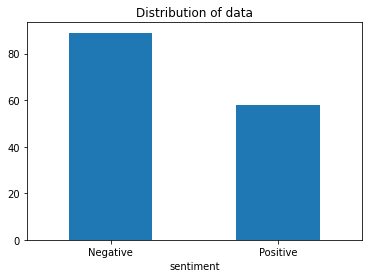

In [26]:

# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)